In [1]:
#!/usr/bin/env python3

import pandas
import lz4.frame
import gzip
import io
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
import datetime
import matplotlib.pyplot as plt

from glob import glob
from plumbum.cmd import rm

#%timeit df[df['Event Time'] == '00:00:00']
#%timeit df.loc[df['Event Time'].values == '00:00:00']
#79.7 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
#22 ms ± 76 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
def load_data(filename, filter_initial=True):
  df = pq.read_table(filename).to_pandas()
  if filter_initial:
    df = df[df['Event Type'] != 'Initial']
  return df

def get_second_data(df, current_second):
  time = sec2string(current_second)
  return df.loc[df['Event Time'].values == time]

def get_minute_data(df, current_minute):
  time = min2string(current_minute)
  next_time = min2string(current_minute + 1)
  return df.loc[(df['Event Time'].values >= time) & (df['Event Time'].values < next_time)]

In [3]:
def sec2string(sec):
  m, s = divmod(sec, 60)
  h, m = divmod(m, 60)
  return "%02d:%02d:%02d" %(h, m, s)

def min2string(minute):
  h, m = divmod(minute, 60)
  return "%02d:%02d:00" %(h, m)

In [4]:
def get_avg_price(df_chunk, prev_price, when):
  df_chunk = df_chunk[df_chunk['Event Type'].values == 'Fill']
  if len(df_chunk) == 0:
    current_avg_price = prev_price
  else:
    if when == 'start':
      current_avg_price = df_chunk.iloc[0, -1]
    elif when == 'end':
      current_avg_price = df_chunk.iloc[-1, -1]
  return current_avg_price

def calc_percent_change(current_price, prev_price):
  percent_change = (current_price - prev_price) / prev_price
  return percent_change

In [5]:
def get_number_of_orders(df_chunk, side='buy', event_type='Place'):
  return len(df_chunk.loc[(df_chunk['Side'].values == side) & (df_chunk['Event Type'].values == event_type)])
                             
def get_volume(df_chunk, side, event_type='Fill'):
  df_chunk = df_chunk.loc[(df_chunk['Side'].values == side) & (df_chunk['Event Type'].values == event_type)]
  return sum(df_chunk['Fill Price (USD)']*df_chunk['Fill Quantity (BTC)'])

def get_market_limit_ratio(df_chunk):
  num_market = len(df_chunk.loc[df_chunk['Order Type'].values == 'market'])
  num_limit = len(df_chunk.loc[df_chunk['Order Type'].values == 'limit'])
  return num_market / (num_limit + 1e-9)

In [6]:
def one_hot(index, length):
  onehot = [0.]*length
  onehot[index] = 1.
  return onehot
    
def extract_temporal_features(df_chunk, minute):
  try:
    year, month, day = df_chunk['Event Date'].values[0].split('-')
  except:
    print(minute)
  #week_of_year = int(datetime.datetime(int(year), int(month), int(day)).isocalendar()[1]) - 1
  day_of_week = int(datetime.datetime(int(year), int(month), int(day)).weekday())
  hour = int(df_chunk['Event Time'].values[0][0:2])
  month = int(month) - 1
  #return one_hot(month, 12), one_hot(week_of_year, 52), one_hot(day_of_week, 7), one_hot(hour, 24)
  return one_hot(month, 12), one_hot(day_of_week, 7), one_hot(hour, 24)

In [7]:
def get_all_features(df_chunk, prev_price, minute):
  # Computes:
  # Percent change of average price
  # Ratio of number of buy to sell orders placed
  # Ratio of number of buy to sell orders executed
  # include cancelled??
  # Ratio of buy to sell volume
  # Ratio of number of market to limit orders
  # One-hot encodings of month, week, and hour
  
  # Get current price, calculate percent change
  current_price = get_avg_price(df_chunk, prev_price, when='end')
  percent_change = calc_percent_change(current_price, prev_price)

  # Ratios of number of buy to sell orders placed, executed, and cancelled
  buy_place    = get_number_of_orders(df_chunk, side='buy', event_type='Place')
  buy_exec     = get_number_of_orders(df_chunk, side='buy', event_type='Fill')
  buy_cancel   = get_number_of_orders(df_chunk, side='buy', event_type='Cancel')
  sell_place   = get_number_of_orders(df_chunk, side='sell', event_type='Place')
  sell_exec    = get_number_of_orders(df_chunk, side='sell', event_type='Fill')
  sell_cancel  = get_number_of_orders(df_chunk, side='sell', event_type='Cancel')
  epsilon = 1e-9
  ratio_place  = buy_place / (sell_place + epsilon)
  ratio_exec   = buy_exec / (sell_exec  + epsilon)
  ratio_cancel = buy_cancel / (sell_cancel + epsilon)
  
  # Ratio of buy to sell volume
  ratio_volume = get_volume(df_chunk, side='buy') / (get_volume(df_chunk, side='sell') + epsilon)
  
  # Ratio of market to limit orders
  ratio_market_limit = get_market_limit_ratio(df_chunk) 
  
  # Temporal features
  #month, week, day, hour = extract_temporal_features(df_chunk)
  month_vec, day_vec, hour_vec = extract_temporal_features(df_chunk, minute)
  
  return [current_price, percent_change, ratio_place, ratio_exec, ratio_cancel, 
          ratio_volume, ratio_market_limit, 
          month_vec, day_vec, hour_vec]

In [8]:
def write_tmp_parquet(df, outfile):
  outfile = outfile.replace('cboe/parquet_BTCUSD/', 'cboe/parquet_preprocessed2_BTCUSD/')
  pq.write_table(pa.Table.from_pandas(df), outfile, compression='snappy')

In [9]:
def check_number_of_events(df, timesteps, resolution='minute', event_type=None, order_type=None):
  
  # Filter data
  if event_type is not None:
    df = df.loc[df['Event Type'].values == event_type]
  if order_type is not None:
    df = df.loc[df['Order Type'].values == order_type]
  
  chunk_lengths = []
  # Minute resolution
  if resolution == 'minute':
    for minute in range(timesteps):
      chunk_lengths.append(len(get_minute_data(df, minute)))
      if minute%200 == 0:
        print('Minute:', minute)
        
  # Second resolution
  elif resolution == 'second':
    for sec in range(timesteps):
      chunk_lengths.append(len(get_second_data(df, sec)))
      if sec%100 == 0:
        print('Second', sec)

  # Visualize
  plt.figure(figsize=(20,2));
  plt.plot(chunk_lengths);
  plt.figure(figsize=(20,5));
  plt.hist(chunk_lengths, bins=40);
  
  return chunk_lengths

In [10]:
def calculate_y(new_df):
  new_df['y_percent_change'] = new_df['percent_change']
  new_df['y_percent_change'] = new_df['y_percent_change'].shift(-1)
  new_df = new_df[:-1]
  return new_df

In [11]:
def preprocess_createXY_single_day(filename, visualize=True):
  print(filename)
  df = load_data(filename, filter_initial=True)
#   columns = ['percent_change', 
#              'ratio_place', 'ratio_exec', 'ratio_cancel',
#              'ratio_volume', 'ratio_market_limit',
#              'month_vec', 'day_vec', 'hour_vec',
#              'Y_next_percent_change']
  columns = ['percent_change', 
             'ratio_place', 'ratio_exec', 'ratio_cancel',
             'ratio_volume', 'ratio_market_limit',
             'm0','m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11',
             'd0','d1','d2','d3','d4','d5','d6',
             'h0','h1','h2','h3','h4','h5','h6','h7','h8','h9','h10','h11',
             'h12','h13','h14','h15','h16','h17','h18','h19','h20','h21','h22','h23']
  new_df = pandas.DataFrame(columns=columns)
  
  # Initialize previous price
  prev_price = get_avg_price(df, None, when='start')
  all_X = []
  for minute in range(24*60):
    #if minute%100 == 0:
    #  print('Minutes:', minute)
      
    # Select one minute of data from order book
    df_chunk = get_minute_data(df, minute)
    if len(df_chunk) == 0: # skip missing data
      continue
    
    # Extract features, X
    X = get_all_features(df_chunk, prev_price, minute)
    all_X.append(X)
    prev_price = X[0]
    row = X
    
    # quick little hack...
    row1=[]
    for v in row:
      if type(v)==list:
        for q in v:
          row1.append(q)
      else:
        row1.append(v)
    # Add to df
    new_df.loc[len(new_df)] = row1[1:]
    
  # Write tmp file to later be concatenated with all others
  
  # Compute labels, Y
  new_df = calculate_y(new_df)
  
  write_tmp_parquet(new_df, filename)
  
  if visualize:
    visualize_features(all_X)

  return new_df

In [12]:
def visualize_features(features):
  titles=['current_price', 'percent_change', 'Ratio of Placed Orders (buy/sell)','Ratio of Filled Orders (buy/sell)', 
          'Ratio of Cancelled Orders (buy/sell)', 'Ratio of Volume (buy/sell)', 'Ratio of Number of Market/Limit orders',
         'month','day','hour']
  for i in range(7):
    a = [x[i] for x in features]
    plt.figure(figsize=(20,2));
    plt.plot(a); 
    plt.title(titles[i])
  for i in range(7,10):
    a = [x[i].index(1) for x in features]
    plt.figure(figsize=(20,2));
    plt.plot(a);
    plt.title(titles[i])

In [13]:
# # Visualize events
# event_type = "Fill"
# order_type = None
# resolution = 'minute'
# timesteps = 24*60

# chunk_lengths = check_number_of_events(df, timesteps=timesteps, resolution=resolution,
#                                        event_type=event_type, order_type=order_type)

cboe/parquet_BTCUSD/BTCUSD_order_book_20151008.parquet
cboe/parquet_BTCUSD/BTCUSD_order_book_20160116.parquet
cboe/parquet_BTCUSD/BTCUSD_order_book_20160425.parquet


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cboe/parquet_BTCUSD/BTCUSD_order_book_20160803.parquet
cboe/parquet_BTCUSD/BTCUSD_order_book_20161111.parquet
cboe/parquet_BTCUSD/BTCUSD_order_book_20170530.parquet
cboe/parquet_BTCUSD/BTCUSD_order_book_20171216.parquet


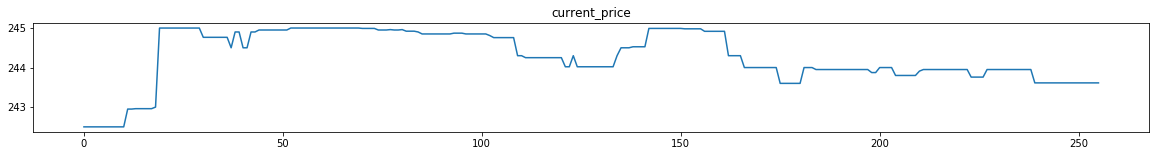

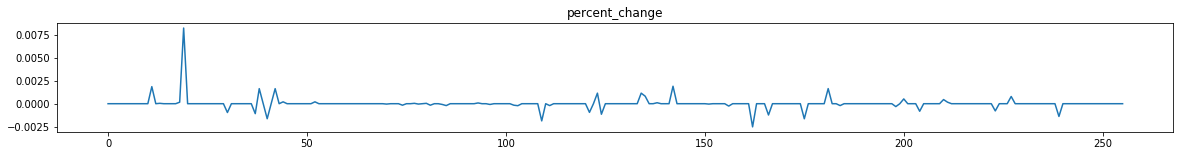

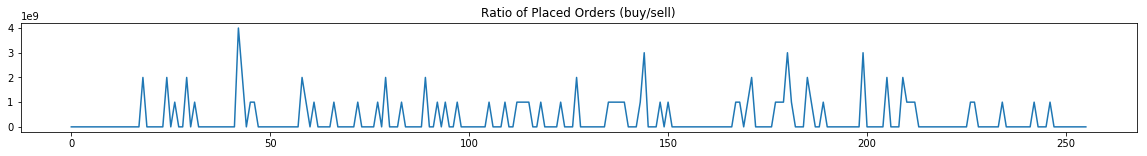

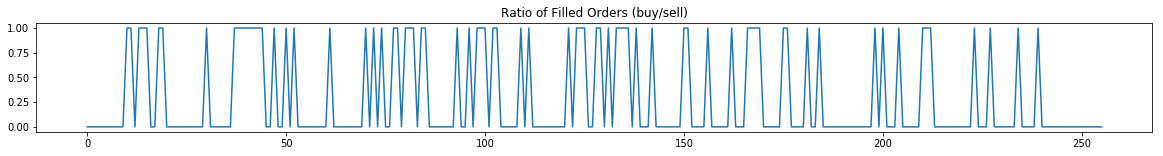

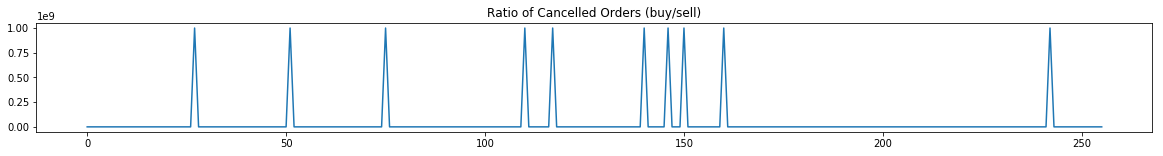

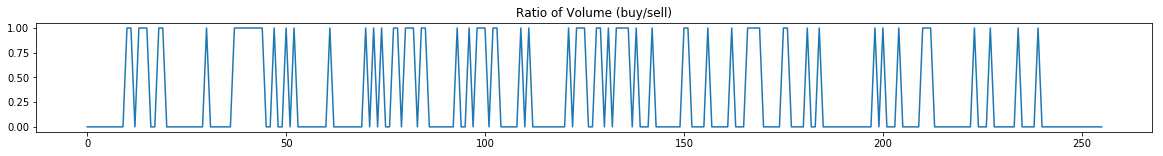

In [ ]:
test_days = [0,100,200,300,400,600,800]
for day in test_days:
  new_df = preprocess_createXY_single_day(filename = sorted(glob('cboe/parquet_BTCUSD/*.parquet'))[day])

In [ ]:
# Preprocess all files
filenames = sorted(glob('cboe/parquet_BTCUSD/*.parquet'))
count = 0
for filename in filenames:
  preprocess_createXY_single_day(filename, visualize=False)
  count += 1
  print(count, '/', len(filenames))